In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [25]:
train_data = pd.read_csv('train_new.csv')
test_data = pd.read_csv('test_new.csv')

In [26]:
train_data.isnull().sum()

SalePrice          0
PID                0
Lot Frontage     362
Lot Area           0
Street             0
Neighborhood       0
Bldg Type          0
House Style        0
Overall Qual       0
Overall Cond       0
Year Built         0
Roof Style         0
Heating            0
Central Air        0
Electrical         1
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
TotRms AbvGrd      0
Gr Liv Area        0
Functional         0
Screen Porch       0
Pool Area          0
Yr Sold            0
Sale Type          0
dtype: int64

In [27]:
train_data.dtypes

SalePrice          int64
PID                int64
Lot Frontage     float64
Lot Area           int64
Street            object
Neighborhood      object
Bldg Type         object
House Style       object
Overall Qual       int64
Overall Cond       int64
Year Built         int64
Roof Style        object
Heating           object
Central Air       object
Electrical        object
Full Bath          int64
Half Bath          int64
Bedroom AbvGr      int64
TotRms AbvGrd      int64
Gr Liv Area        int64
Functional        object
Screen Porch       int64
Pool Area          int64
Yr Sold            int64
Sale Type         object
dtype: object

In [28]:
train_data['SalePrice'].describe()

count      2197.000000
mean     182376.851161
std       81168.157405
min       13100.000000
25%      130000.000000
50%      163500.000000
75%      215000.000000
max      755000.000000
Name: SalePrice, dtype: float64

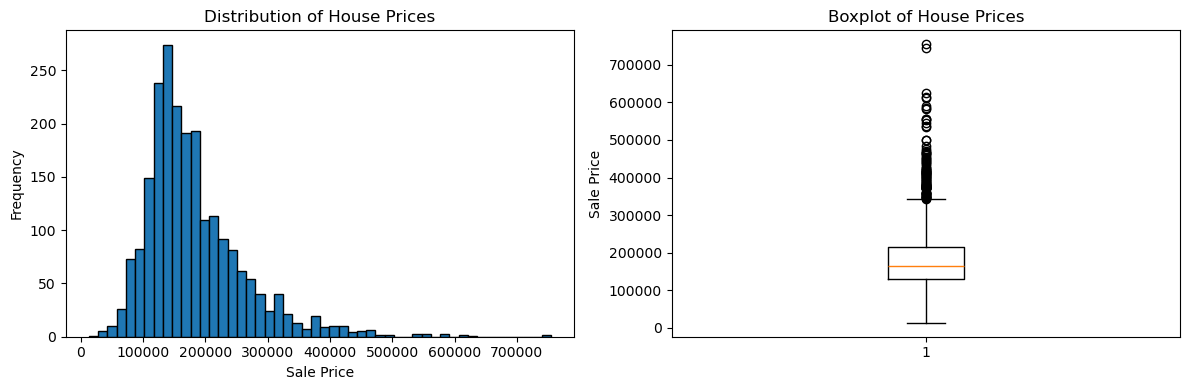

In [29]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train_data['SalePrice'], bins=50, edgecolor='black')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.title('Distribution of House Prices')

plt.subplot(1, 2, 2)
plt.boxplot(train_data['SalePrice'])
plt.ylabel('Sale Price')
plt.title('Boxplot of House Prices')

plt.tight_layout()
plt.show()

In [30]:
train_data['Lot Frontage'].fillna(train_data['Lot Frontage'].median(), inplace=True)
test_data['Lot Frontage'].fillna(test_data['Lot Frontage'].median(), inplace=True)

<positron-console-cell-30>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


<positron-console-cell-30>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col

In [31]:
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']

In [32]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_features

['PID',
 'Lot Frontage',
 'Lot Area',
 'Overall Qual',
 'Overall Cond',
 'Year Built',
 'Full Bath',
 'Half Bath',
 'Bedroom AbvGr',
 'TotRms AbvGrd',
 'Gr Liv Area',
 'Screen Porch',
 'Pool Area',
 'Yr Sold']

In [33]:
X_numeric = X[numeric_features]
test_numeric = test_data[numeric_features]

X_numeric.shape, test_numeric.shape

((2197, 14), (605, 14))

In [34]:
X_train, X_val, y_train, y_val = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

X_train.shape, X_val.shape

((1757, 14), (440, 14))

In [35]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=10),
    'Lasso Regression': Lasso(alpha=10),
    'Decision Tree': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
}

In [36]:
rf_selector = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_selector.fit(X_train, y_train)

n_features = 10
importances = rf_selector.feature_importances_
selected_indices = np.argsort(importances)[::-1][:n_features]
selected_features = X_train.columns[selected_indices]

feature_rank_df = pd.DataFrame({
    'Feature': selected_features,
    'Importance': importances[selected_indices]
})

X_train_selected = X_train.iloc[:, selected_indices]
X_val_selected = X_val.iloc[:, selected_indices]

(X_train.shape[1], X_train_selected.shape[1], feature_rank_df)

(14,
 10,
          Feature  Importance
 0   Overall Qual    0.653570
 1    Gr Liv Area    0.157209
 2       Lot Area    0.050342
 3     Year Built    0.044954
 4            PID    0.025604
 5   Lot Frontage    0.018667
 6  Bedroom AbvGr    0.009383
 7      Full Bath    0.008323
 8   Overall Cond    0.006897
 9  TotRms AbvGrd    0.006763)

In [37]:
fitted_models = {name: model.fit(X_train_selected, y_train) for name, model in models.items()}

results = {
    name: {
        'model': fitted_models[name],
        'train_r2': r2_score(y_train, fitted_models[name].predict(X_train_selected)),
        'val_r2': r2_score(y_val, fitted_models[name].predict(X_val_selected)),
        'val_rmse': np.sqrt(mean_squared_error(y_val, fitted_models[name].predict(X_val_selected))),
        'val_mae': mean_absolute_error(y_val, fitted_models[name].predict(X_val_selected)),
        'selected_features': selected_features,
        'n_features': len(selected_features)
    }
    for name in fitted_models.keys()
}

best_model_name = max(results, key=lambda x: results[x]['val_r2'])
best_model_name, results[best_model_name]['val_r2'], results[best_model_name]['n_features']

/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=3.53859e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


('Gradient Boosting', 0.8582799467932019, 10)

In [38]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train R²': [results[m]['train_r2'] for m in results.keys()],
    'Validation R²': [results[m]['val_r2'] for m in results.keys()],
    'RMSE': [results[m]['val_rmse'] for m in results.keys()],
    'MAE': [results[m]['val_mae'] for m in results.keys()]
})

comparison_df

,Model,Train R²,Validation R²,RMSE,MAE
0,Linear Regression,0.786472,0.731740,37690.299593,24755.398211
1,Ridge Regression,0.786468,0.731763,37688.649529,24750.772599
2,Lasso Regression,0.786472,0.731773,37687.985627,24755.102945
3,Decision Tree,0.971470,0.614638,45173.715576,25562.335140
4,Random Forest,0.968627,0.809255,31781.758376,18787.132835
5,Gradient Boosting,0.975268,0.858280,27394.735222,17951.853113


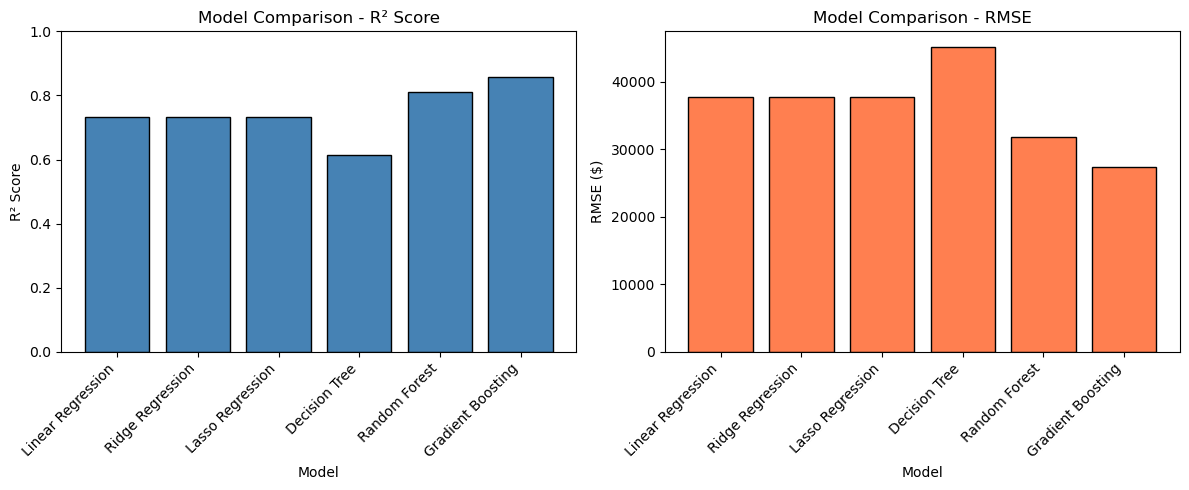

In [39]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
x_pos = np.arange(len(comparison_df))
plt.bar(x_pos, comparison_df['Validation R²'], color='steelblue', edgecolor='black')
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison - R² Score')
plt.xticks(x_pos, comparison_df['Model'], rotation=45, ha='right')
plt.ylim([0, 1])

plt.subplot(1, 2, 2)
plt.bar(x_pos, comparison_df['RMSE'], color='coral', edgecolor='black')
plt.xlabel('Model')
plt.ylabel('RMSE ($)')
plt.title('Model Comparison - RMSE')
plt.xticks(x_pos, comparison_df['Model'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

In [40]:
best_model = results[best_model_name]['model']

(best_model_name, results[best_model_name]['val_r2'], results[best_model_name]['val_rmse'])

('Gradient Boosting', 0.8582799467932019, np.float64(27394.735221824518))

In [41]:
feature_importance = pd.DataFrame({
    'Feature': selected_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False) if hasattr(best_model, 'feature_importances_') else pd.DataFrame()

feature_importance.head(10)

,Feature,Importance
0,Overall Qual,0.657131
1,Gr Liv Area,0.170481
3,Year Built,0.051301
2,Lot Area,0.051174
4,PID,0.031002
5,Lot Frontage,0.013843
6,Bedroom AbvGr,0.011568
8,Overall Cond,0.008293
9,TotRms AbvGrd,0.002951
7,Full Bath,0.002254


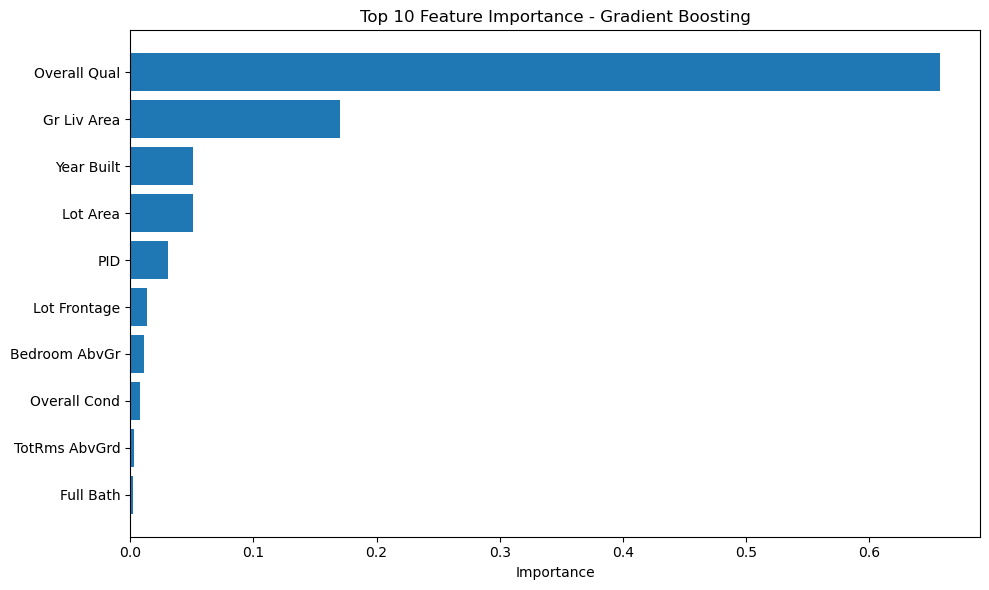

In [42]:
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title(f'Top 10 Feature Importance - {best_model_name}')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [43]:
best_model.fit(X_numeric, y)
test_predictions = best_model.predict(test_numeric)

(len(test_predictions), test_predictions.mean(), test_predictions.min(), test_predictions.max())

(605,
 np.float64(175036.11497171767),
 np.float64(49229.42819103277),
 np.float64(509695.977847418))

In [ ]:
submission = pd.DataFrame({
    'PID': test_data['PID'],
    'SalePrice': test_predictions
})

submission.to_csv('predictions.csv', index=False)

,PID,SalePrice
0,907135180,138084.730073
1,528181040,204585.083404
2,528175010,211025.092211
3,531379030,193819.213242
4,923275090,124638.613831
5,528181070,238336.156262
6,908103280,137072.826027
7,902201110,127394.538187
8,905103070,142522.534170
9,527162180,182717.084231


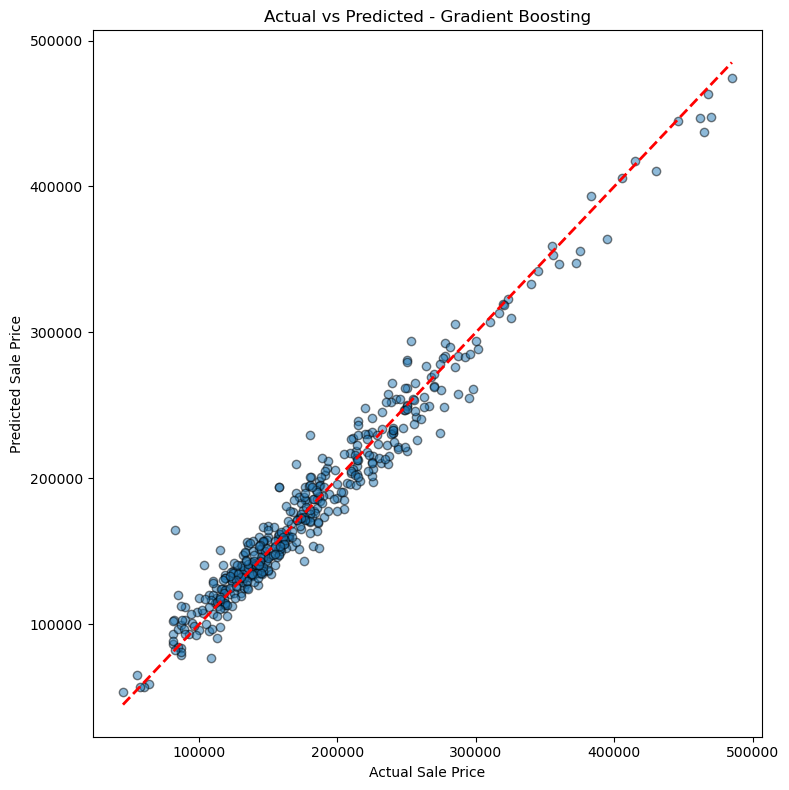

In [46]:
y_pred_val_best = best_model.predict(X_val)

plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_val_best, alpha=0.5, edgecolor='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.tight_layout()
plt.show()

In [47]:
summary_stats = pd.DataFrame({
    'Metric': ['Best Model', 'Model Accuracy (R²)', 'Average Prediction Error', 'RMSE',
               'Training Data Size', 'Number of Features Used', 'Test Predictions',
               'Min Training Price', 'Avg Training Price', 'Max Training Price',
               'Min Predicted Price', 'Avg Predicted Price', 'Max Predicted Price'],
    'Value': [best_model_name,
              f"{results[best_model_name]['val_r2']:.4f}",
              f"${results[best_model_name]['val_mae']:,.2f}",
              f"${results[best_model_name]['val_rmse']:,.2f}",
              f"{len(train_data):,}",
              f"{len(numeric_features)}",
              f"{len(test_predictions):,}",
              f"${train_data['SalePrice'].min():,.2f}",
              f"${train_data['SalePrice'].mean():,.2f}",
              f"${train_data['SalePrice'].max():,.2f}",
              f"${test_predictions.min():,.2f}",
              f"${test_predictions.mean():,.2f}",
              f"${test_predictions.max():,.2f}"]
})

summary_stats

,Metric,Value
0,Best Model,Gradient Boosting
1,Model Accuracy (R²),0.8583
2,Average Prediction Error,"$17,951.85"
3,RMSE,"$27,394.74"
4,Training Data Size,"2,197"
5,Number of Features Used,14
6,Test Predictions,605
7,Min Training Price,"$13,100.00"
8,Avg Training Price,"$182,376.85"
9,Max Training Price,"$755,000.00"


In [48]:
import os
if not os.path.exists("dashboard_plots"):
    os.makedirs("dashboard_plots")

In [49]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(train_data['SalePrice'], bins=50, color='steelblue', edgecolor='black')
plt.xlabel('Sale Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of House Prices', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.boxplot(train_data['SalePrice'], patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='steelblue'),
            medianprops=dict(color='red', linewidth=2))
plt.ylabel('Sale Price ($)', fontsize=12)
plt.title('Price Distribution (Boxplot)', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('dashboard_plots/chart1_price_distribution.png', dpi=150, bbox_inches='tight')
plt.close()

In [50]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
models_list = list(results.keys())
r2_scores = [results[m]['val_r2'] for m in models_list]
colors = ['#48bb78' if m == best_model_name else 'steelblue' for m in models_list]

x_pos = np.arange(len(models_list))
plt.bar(x_pos, r2_scores, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Model', fontsize=12)
plt.ylabel('R² Score', fontsize=12)
plt.title('Model Performance - R² Score', fontsize=14, fontweight='bold')
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.ylim([0.75, 0.95])
plt.grid(axis='y', alpha=0.3)
plt.axhline(y=0.85, color='red', linestyle='--', alpha=0.5, label='Target: 0.85')
plt.legend()

plt.subplot(1, 2, 2)
rmse_values = [results[m]['val_rmse'] for m in models_list]
plt.bar(x_pos, rmse_values, color=colors, edgecolor='black', linewidth=1.5)
plt.xlabel('Model', fontsize=12)
plt.ylabel('RMSE ($)', fontsize=12)
plt.title('Model Performance - RMSE', fontsize=14, fontweight='bold')
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('dashboard_plots/chart2_model_comparison.png', dpi=150, bbox_inches='tight')
plt.close()

In [51]:
feature_importance_full = pd.DataFrame({
    'Feature': numeric_features,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False).head(10) if hasattr(best_model, 'feature_importances_') else pd.DataFrame()

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance_full)), feature_importance_full['Importance'],
         color='steelblue', edgecolor='black', linewidth=1.5)
plt.yticks(range(len(feature_importance_full)), feature_importance_full['Feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.title(f'Top 10 Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('dashboard_plots/chart3_feature_importance.png', dpi=150, bbox_inches='tight')
plt.close()

In [52]:
y_pred_val_best = best_model.predict(X_val)

plt.figure(figsize=(8, 8))
plt.scatter(y_val, y_pred_val_best, alpha=0.6, color='steelblue', edgecolor='black', s=50)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()],
         'r--', lw=3, label='Perfect Prediction')
plt.xlabel('Actual Sale Price ($)', fontsize=12)
plt.ylabel('Predicted Sale Price ($)', fontsize=12)
plt.title(f'Actual vs Predicted - {best_model_name}', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('dashboard_plots/chart4_actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.close()

In [53]:
residuals = y_val - y_pred_val_best

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_val_best, residuals, alpha=0.6, color='coral', edgecolor='black', s=50)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Sale Price ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, color='coral', edgecolor='black')
plt.xlabel('Residuals ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Residuals', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('dashboard_plots/chart5_residuals.png', dpi=150, bbox_inches='tight')
plt.close()

In [54]:
dashboard_metrics = pd.DataFrame({
    'Metric': ['Model Accuracy', 'Avg Prediction Error', 'Training Dataset', 'Predictions Made'],
    'Value': [f"{results[best_model_name]['val_r2']*100:.1f}%",
              f"${results[best_model_name]['val_mae']:,.0f}",
              f"{len(train_data):,}",
              f"{len(test_predictions):,}"]
})

model_comparison_table = pd.DataFrame([
    {
        'Model': name,
        'R² Score': results[name]['val_r2'],
        'RMSE': f"${results[name]['val_rmse']:,.0f}",
        'MAE': f"${results[name]['val_mae']:,.0f}",
        'Status': '✓ SELECTED' if name == best_model_name else '—'
    }
    for name in results.keys()
])

feature_dashboard = pd.DataFrame([
    {'Feature': row['Feature'], 'Bar Width (px)': int(row['Importance'] * 500)}
    for _, row in (pd.DataFrame({
        'Feature': numeric_features,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(6).iterrows())
]) if hasattr(best_model, 'feature_importances_') else pd.DataFrame()

price_statistics = pd.DataFrame({
    'Statistic': ['Training Avg', 'Training Min', 'Training Max'],
    'Value': [f"${train_data['SalePrice'].mean():,.0f}",
              f"${train_data['SalePrice'].min():,.0f}",
              f"${train_data['SalePrice'].max():,.0f}"]
})

dashboard_metrics, model_comparison_table, feature_dashboard, price_statistics

(                 Metric    Value
 0        Model Accuracy    85.8%
 1  Avg Prediction Error  $17,952
 2      Training Dataset    2,197
 3      Predictions Made      605,
                Model  R² Score     RMSE      MAE      Status
 0  Linear Regression  0.731740  $37,690  $24,755           —
 1   Ridge Regression  0.731763  $37,689  $24,751           —
 2   Lasso Regression  0.731773  $37,688  $24,755           —
 3      Decision Tree  0.614638  $45,174  $25,562           —
 4      Random Forest  0.809255  $31,782  $18,787           —
 5  Gradient Boosting  0.858280  $27,395  $17,952  ✓ SELECTED,
          Feature  Bar Width (px)
 0   Overall Qual             324
 1    Gr Liv Area              79
 2     Year Built              26
 3       Lot Area              23
 4            PID              16
 5  Bedroom AbvGr               5,
       Statistic     Value
 0  Training Avg  $182,377
 1  Training Min   $13,100
 2  Training Max  $755,000)